# Access Database-Files to explore and summerise Data

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
from tables import *
import sqlite3
import openpyxl as oxl

In [2]:
# aims 
    # plot single data and highlight outliers in data
    # compare epsilon values of different evaluation methods
    # summarise data
    # calculate epsilon values with SSB
    # visulise data for epsilon SSB
    # store summarised data in hd5

In [3]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2016-03-10/data_eval_new/"
file_name = "int_norm_20160310_bgd_new.h5"
path_comp = '/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/'
sum_file = "int_norm_comp_new.h5"

In [4]:
hdf5_file = pd.HDFStore(path+file_name)
#hdf5_sum_file = pd.HDFStore(path_comp+sum_file)

# Methods for Outlier rejection, Summarise and SSB Calculation

In [5]:
def mad_based_outlier(points, thresh=3.5):
        """
        Returns a boolean array with True if points are outliers and False
        otherwise.

        Parameters:
        -----------
            points : An numobservations by numdimensions array of observations
            thresh : The modified z-score to use as a threshold. Observations with
                a modified z-score (based on the median absolute deviation) greater
                than this value will be classified as outliers.

        Returns:
        --------
            mask : A numobservations-length boolean array.

        References:
        ----------
            Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
            Handle Outliers", The ASQC Basic References in Quality Control:
            Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
        """
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

#outlier rejection
def mad_outlier_rejection(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(~mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Cycle", "Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Cycle"] = df["Cycle"]
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier_mean(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = np.nanstd(x, ddof=1) * 2
    return SD2

def df_mean(df):
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).mean()
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    columns = ["Filenumber", "Sample"]
    columns.extend(df.drop(["Filenumber", "Sample"], axis=1).columns)
    df = pd.DataFrame(df, columns = columns)
    
    return df
    
def df_SD(df):    
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).agg([np.mean, SD2])
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    
    return df

def SSB(df, std, multi_fac):
    ### calculate Standard-Sample Bracketing ###

    # bracketing standard #
    std_used = std
    df_to_use = df
    # determine at which position the samples are which are bracketed
    sub_index = df_to_use[(df_to_use["Sample"].shift(1) == df_to_use["Sample"].shift(-1)) & (df_to_use["Sample"].shift(1) == std_used)].index
    # remove measurements with values below 0.1V
    corr_values = df_to_use
    # extract only standard data
    corr_values_2 = df_to_use[df_to_use["Sample"] == std_used]

    # save sample names
    sample = corr_values["Sample"]
    sample_2 = corr_values_2["Sample"]

    # remove sample names from dataframe for calculation
    new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
    new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

    # calculate bracketing 
    epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*multi_fac
    epsilon_2 = ((new_2 / ((new_2.shift(1) + new_2.shift(-1))/2))-1)*multi_fac
    # reinsert samples names
    epsilon_NIST["Sample"] = sample
    epsilon_2["Sample"] = sample_2

    # select samples by bracketing index
    epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
    #epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"].str.contains("opt")]
    # select only bracketed sample measurements in dataframe
    epsilon_NIST= epsilon_NIST[epsilon_NIST["Sample"] != std_used]
    # select only bracketed standard measurements in dataframe
    epsilon_2 = epsilon_2[epsilon_2["Sample"] == std_used]
    # append bracketed sample and standard measurements
    epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
    # sort dataframe by datetime
    epsilon_comp = epsilon_comp.sort_index(axis=0)
    
    return epsilon_comp

def plot_epsilon(df, sel_ratio, std, xlim):
    x = range(1, len(epsilon_sum.index)+1)
    plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
    plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
    plt.xlim(xlim)
    plt.ylim([0.5, len(epsilon_sum.index)+1])
    plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
    plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
    #savefig(path+"epsilon_118.pdf", bbox_inches='tight')

# Datafiles in Database

In [6]:
hdf5_file.keys()

['/raw_data/baselines',
 '/raw_data/signals_raw',
 '/raw_data/signals_zero',
 '/evaluation/bgd_outlier_corr/df_bgd_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118_120/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118

# Plot raw data and check measurement

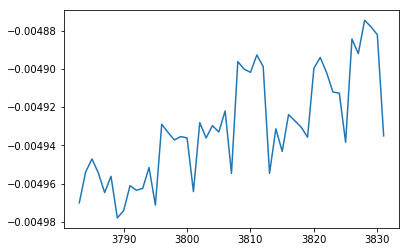

In [10]:
# Check Baselines
column = "116"

baseline = hdf5_file['/raw_data/baselines']
#baseline = baseline[baseline["Filenumber"] == 8979]
plt.plot(baseline["Filenumber"], baseline[column])
plt.show()

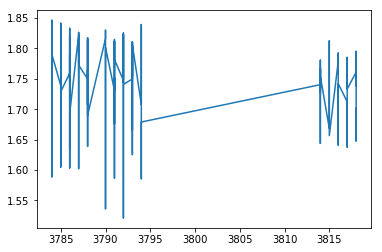

In [11]:
# Check Signals
column = "122"
sample = "NIST 100ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_sub = signals[signals["Sample"] == sample]
plt.plot(signals_sub["Filenumber"], signals_sub[column])
plt.show()

In [12]:
df_mean(signals[signals["Sample"] != "blank sol"])["Sample"].unique()

array(['NIST 100ppb', 'NIST 200ppb', 'SPEX1 200ppb', 'NIST 350ppb'], dtype=object)

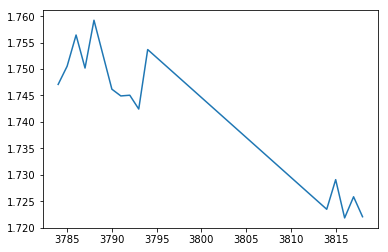

In [13]:
# Check Signals - mean
column = "122"
sample = "NIST 100ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_mean = df_mean(signals)
signals_sub_mean = signals_mean[signals_mean["Sample"] == sample]
plt.plot(signals_sub_mean["Filenumber"], signals_sub_mean[column])
plt.show()

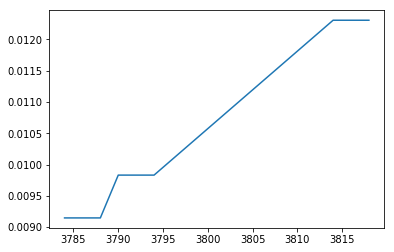

In [14]:
# Check background 
column = "120"
sample = "NIST 100ppb"

background = hdf5_file['/evaluation/bgd_outlier_corr/df_bgd_corr']
background_sub = background[background["Sample"] == sample]
plt.plot(background_sub["Filenumber"], background_sub[column])
plt.show()

In [15]:
background_mean = df_mean(background)

In [16]:
# Create Dataframe for signals_bgd corr
signals["Te/Sn"] = (signals["125_2"]/7.050686)/(signals["118"]/24.223)
signals["Cd/Sn"] = (signals["111"]/12.9447)/(signals["118"]/24.223)

In [17]:
signals_mean = signals.groupby("Filenumber").agg("mean")

# Outlier rejection

In [133]:
bgd_method = 'bgd_outlier_corr' #'no_bgd_corr'
norm_ratio = "r_122_118"
interf_corr = "Te125_Xe129_corr"

In [134]:
df_all_raw_rat = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_raw_ratios_af_interf_corr']
df_mean_int_corr = df_mean(hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_amount_interf_corr'])
df_all = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_internal_norm']

In [135]:
column = "124/118"
sample = "NIST 200ppb"

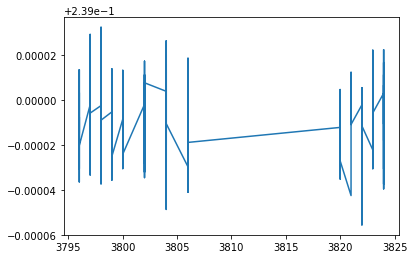

In [136]:
# Check ratios for bracketing standard

df_all_sub = df_all[df_all["Sample"] == sample]
plt.plot(df_all_sub["Filenumber"], df_all_sub[column])
plt.show()

In [137]:
df_outlier_rej_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier)

df_outlier_rej_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in divide


In [138]:
df_outlier_rej_int

,Sample,Num_of_Ana_Cyc,Cycle,Filenumber,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118
Date,,,,,,,,,,,,,
2016-03-10 17:41:00,NIST 100ppb,2,1,3784,0.040138,0.027186,0.013946,0.600257,0.316700,0.354639,1.345999,0.19125,0.239001
2016-03-10 17:41:00,NIST 100ppb,2,2,3784,0.040131,0.027163,0.013935,0.600227,0.316697,0.354623,1.346036,0.19125,0.238976
2016-03-10 17:41:00,NIST 100ppb,2,3,3784,0.040127,0.027167,0.013945,0.600255,0.316688,0.354635,1.345969,0.19125,0.238989
2016-03-10 17:41:00,NIST 100ppb,2,4,3784,0.040136,0.027190,0.013943,0.600284,0.316700,0.354612,1.345971,0.19125,0.238981
2016-03-10 17:41:00,NIST 100ppb,2,5,3784,0.040125,0.027182,0.013940,0.600253,0.316704,0.354620,1.345970,0.19125,0.238968
2016-03-10 17:41:00,NIST 100ppb,2,6,3784,0.040125,0.027162,0.013943,0.600216,0.316687,0.354620,1.346049,0.19125,0.239025
2016-03-10 17:41:00,NIST 100ppb,2,7,3784,0.040129,0.027169,0.013940,0.600253,0.316715,0.354634,1.346024,0.19125,0.238997
2016-03-10 17:41:00,NIST 100ppb,2,8,3784,0.040138,0.027191,0.013947,0.600253,0.316692,0.354647,1.346033,0.19125,0.239019
2016-03-10 17:41:00,NIST 100ppb,2,9,3784,0.040136,0.027169,0.013939,0.600251,0.316724,0.354608,1.345959,NaN,0.238967


In [139]:
df_outlier_int[df_outlier_int[column].notnull()][column]

Filenumber  Date               
3816        2016-03-11 03:13:00    0.238936
3828        2016-03-11 06:46:00    0.239002
            2016-03-11 06:46:00    0.239001
            2016-03-11 06:46:00    0.239006
Name: 124/118, dtype: float64

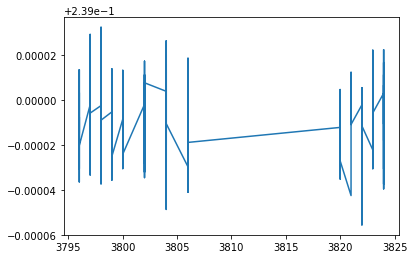

In [140]:
# Check sample measurements
df = df_outlier_rej_int

df_sub = df[df["Sample"] == sample]
plt.plot(df_sub["Filenumber"], df_sub[column])
plt.show()

In [141]:
df[df["Sample"] == sample][column].std()

1.3026999257511351e-05

In [142]:
df_outlier_rej_int["Cd/Sn"] = signals[(signals["Sample"] != "blank sol") & (signals["Sample"] != "SQ")]["Cd/Sn"]
df_outlier_rej_int["Te/Sn"] = signals[(signals["Sample"] != "blank sol") & (signals["Sample"] != "SQ")]["Te/Sn"]

In [143]:
data_mean_int = df_mean(df_outlier_rej_int)
data_mean_int_sd = df_SD(df_outlier_rej_int)

data_mean_raw = df_mean(df_outlier_rej_raw)
data_mean_raw_sd = df_SD(df_outlier_rej_raw)

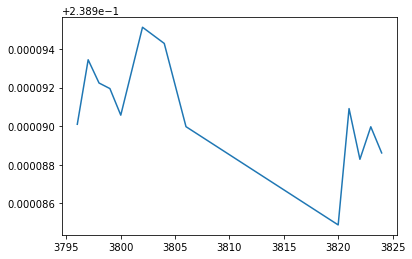

In [144]:
# Check sample measurements
df_mean_used = data_mean_int

df_mean_sub = df_mean_used[df_mean_used["Sample"] == sample]
plt.plot(df_mean_sub["Filenumber"], df_mean_sub[column])
plt.show()

In [145]:
data_mean_raw

,Filenumber,Sample,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118
Date,,,,,,,,,,,
2016-03-10 17:41:00,3784,NIST 100ppb,0.037087,0.025792,0.013411,0.584909,0.312658,0.359191,1.380705,0.201155,0.257641
2016-03-10 18:00:00,3785,NIST 100ppb,0.037077,0.025785,0.013409,0.584862,0.312652,0.359210,1.380820,0.201188,0.257702
2016-03-10 18:19:00,3786,NIST 100ppb,0.037070,0.025782,0.013408,0.584837,0.312647,0.359218,1.380927,0.201218,0.257753
2016-03-10 18:38:00,3787,NIST 100ppb,0.037064,0.025782,0.013409,0.584798,0.312637,0.359222,1.380986,0.201239,0.257792
2016-03-10 18:57:00,3788,NIST 100ppb,0.037056,0.025774,0.013405,0.584755,0.312628,0.359236,1.381091,0.201267,0.257850
2016-03-10 19:28:00,3790,NIST 100ppb,0.037041,0.025768,0.013405,0.584724,0.312612,0.359254,1.381231,0.201310,0.257932
2016-03-10 19:47:00,3791,NIST 100ppb,0.037039,0.025766,0.013407,0.584734,0.312614,0.359253,1.381201,0.201305,0.257916
2016-03-10 20:06:00,3792,NIST 100ppb,0.037038,0.025763,0.013406,0.584711,0.312607,0.359251,1.381231,0.201308,0.257930
2016-03-10 20:25:00,3793,NIST 100ppb,0.037031,0.025762,0.013406,0.584684,0.312603,0.359262,1.381312,0.201328,0.257972


In [146]:
date_list = []
                         
data_mean_raw = data_mean_raw.drop(date_list)
data_mean_int = data_mean_int.drop(date_list)
data_mean_raw_sd = data_mean_raw_sd.drop(date_list)
data_mean_int_sd = data_mean_int_sd.drop(date_list)

In [147]:
drop_sum = [pd.Timestamp("2016-03-10 17:41:00"),
            pd.Timestamp("2016-03-10 18:00:00")]


In [148]:

data_mean_int_sum = data_mean_int.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_int_sum = data_mean_int_sum.drop("Filenumber", axis=1)

In [149]:
data_mean_raw_sum = data_mean_raw.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_raw_sum = data_mean_raw_sum.drop("Filenumber", axis=1)

In [150]:
data_mean_int_sum

112/118                       114/118                  \
                  mean           SD2 count      mean       SD2 count   
Sample                                                                 
NIST 100ppb   0.040133  6.054838e-06    13  0.027170  0.000007    13   
NIST 200ppb   0.040135  5.693413e-06    13  0.027171  0.000004    13   
NIST 350ppb   0.040135  9.741141e-06    10  0.027171  0.000003    10   
SPEX1 200ppb  0.040135  6.398084e-07     2  0.027169  0.000003     2   

               115/118                       116/118  ...  122/118   124/118  \
                  mean           SD2 count      mean  ...    count      mean   
Sample                                                ...                      
NIST 100ppb   0.013948  4.224173e-06    13  0.600286  ...       13  0.238987   
NIST 200ppb   0.013947  1.657441e-06    13  0.600285  ...       13  0.238991   
NIST 350ppb   0.013948  1.053139e-06    10  0.600314  ...       10  0.238986   
SPEX1 200ppb  0.013957  9.787927e-07     2  0.600287  ...        2  0.238990   

                                     Cd/Sn                     Te/Sn  \
                       SD2 count      mean       SD2 count      mean   
Sample                                                                 
NIST 100ppb   6.052824e-06    13  0.000513  0.000444    13  0.000028   
NIST 200ppb   5.463284e-06    13  0.000192  0.000108    13  0.000028   
NIST 350ppb   7.375286e-06    10  0.000177  0.000423    10  0.000026   
SPEX1 200ppb  8.903106e-07     2  0.000161  0.000015     2  0.000026   

                                  
                       SD2 count  
Sample                            
NIST 100ppb   4.412101e-06    13  
NIST 200ppb   3.056317e-06    13  
NIST 350ppb   1.900816e-06    10  
SPEX1 200ppb  4.722084e-07     2  

[4 rows x 33 columns]

In [151]:
date_list = [pd.Timestamp("2016-03-10 17:41:00"), 
            pd.Timestamp("2016-03-10 18:00:00")]

epsilon_int_NIST_100 = SSB(data_mean_int.drop(date_list), "NIST 100ppb", 10000)
delta_raw_NIST_100 = SSB(data_mean_raw.drop(date_list), "NIST 100ppb", 1000)
epsilon_int_NIST_200= SSB(data_mean_int.drop(date_list), "NIST 200ppb", 10000)
delta_raw_NIST_200 = SSB(data_mean_raw.drop(date_list), "NIST 200ppb", 1000)
epsilon_int_NIST_350= SSB(data_mean_int.drop(date_list), "NIST 350ppb", 10000)
delta_raw_NIST_350 = SSB(data_mean_raw.drop(date_list), "NIST 350ppb", 1000)

In [152]:
epsilon_int_NIST_100 = epsilon_int_NIST_100.drop(["Cd/Sn", "Te/Sn"], axis=1)
epsilon_int_NIST_200 = epsilon_int_NIST_200.drop(["Cd/Sn", "Te/Sn"], axis=1)
epsilon_int_NIST_350 = epsilon_int_NIST_350.drop(["Cd/Sn", "Te/Sn"], axis=1)

In [153]:
delta_raw_NIST_200[delta_raw_NIST_200["Filenumber"] > 1]

,Filenumber,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118,Sample
Date,,,,,,,,,,,
2016-03-11 04:21:00,1.704471,0.023896,0.055581,-0.003672,0.023419,0.011768,-0.004396,-0.022011,-0.027229,-0.063177,NIST 200ppb


In [154]:

date_list = []

epsilon_int_NIST = epsilon_int_NIST.drop(date_list)
delta_raw_NIST = delta_raw_NIST.drop(date_list)
epsilon_int_SPEX = epsilon_int_SPEX.drop(date_list)
delta_raw_SPEX = delta_raw_SPEX.drop(date_list)

NameError: name 'epsilon_int_NIST' is not defined

In [155]:
def epsilon_process(df):
    df = df[(df["Filenumber"] >= -2) & (df["Filenumber"] <= 2)]
    df["Filenumber"] = data_mean_int["Filenumber"].ix[df.index]
    return df

def delta_process(df):
    df = df[(df["Filenumber"] >= -1) & (df["Filenumber"] <= 1)]
    df["Filenumber"] = data_mean_int["Filenumber"].ix[df.index]
    return df

In [156]:
epsilon_int_NIST_100 = epsilon_process(epsilon_int_NIST_100)
delta_raw_NIST_100 = delta_process(delta_raw_NIST_100)
epsilon_int_NIST_200 = epsilon_process(epsilon_int_NIST_200)
delta_raw_NIST_200 = delta_process(delta_raw_NIST_200)
epsilon_int_NIST_350 = epsilon_process(epsilon_int_NIST_350)
delta_raw_NIST_350 = delta_process(delta_raw_NIST_350)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [157]:
epsilon_int_NIST_200

,Filenumber,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118,Sample
Date,,,,,,,,,,,
2016-03-10 21:34:00,3797,-0.577181,-0.162603,-0.982900,-0.228892,0.000783,0.023515,-0.012324,2.220446e-12,0.095252,NIST 200ppb
2016-03-10 21:52:00,3798,0.300767,-0.214903,0.798200,0.182816,-0.002927,0.024326,0.058601,-1.110223e-12,-0.019170,NIST 200ppb
2016-03-10 22:11:00,3799,0.103292,0.298922,-0.825045,-0.116206,-0.005483,-0.020012,-0.046134,-1.110223e-12,0.022803,NIST 200ppb
2016-03-10 22:30:00,3800,-0.989362,-0.547453,0.543340,-0.050390,0.011503,0.056623,0.020354,2.220446e-12,-0.124305,NIST 200ppb
2016-03-10 23:01:00,3802,0.754400,0.376282,0.192419,0.072385,0.014514,-0.085160,0.016793,-1.110223e-12,0.113036,NIST 200ppb
2016-03-10 23:20:00,3803,-0.891395,-0.802843,6.733645,0.010153,0.039540,-0.047121,0.064014,0.000000e+00,-0.187527,SPEX1 200ppb
2016-03-10 23:39:00,3804,0.259394,0.145201,-0.563185,0.052080,-0.050886,0.091969,-0.028675,2.220446e-12,0.072773,NIST 200ppb
2016-03-10 23:58:00,3805,-0.974485,-1.707398,7.098485,-0.048696,-0.047068,-0.007259,-0.054079,2.220446e-12,-0.105926,SPEX1 200ppb
2016-03-11 04:40:00,3821,0.028359,0.014644,0.041544,-0.001062,-0.023246,0.081535,0.074040,-1.110223e-12,0.181352,NIST 200ppb


In [158]:
delta_raw_NIST_200

,Filenumber,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118,Sample
Date,,,,,,,,,,,
2016-03-10 21:34:00,3797,-0.027753,-0.015750,-0.097642,-0.012004,0.005491,-0.004218,-0.014765,-0.021247,-0.031634,NIST 200ppb
2016-03-10 21:52:00,3798,0.055996,0.010152,0.094124,0.022787,-0.000914,0.005420,0.003083,-0.010027,-0.016247,NIST 200ppb
2016-03-10 22:11:00,3799,-0.019245,0.033046,-0.086474,-0.020389,0.000814,-0.004541,0.000078,0.019587,0.030255,NIST 200ppb
2016-03-10 22:30:00,3800,0.074268,0.040708,0.135787,0.056148,0.028045,-0.021087,-0.053916,-0.117999,-0.187422,NIST 200ppb
2016-03-10 23:01:00,3802,-0.163903,-0.122591,-0.105016,-0.077970,-0.039583,0.034825,0.082225,0.156847,0.245233,NIST 200ppb
2016-03-10 23:20:00,3803,-0.680600,-0.456834,0.403813,-0.186837,-0.090122,0.091390,0.192514,0.365047,0.524999,SPEX1 200ppb
2016-03-10 23:39:00,3804,0.221167,0.132349,0.039929,0.070474,0.026695,-0.027470,-0.065735,-0.116338,-0.166894,NIST 200ppb
2016-03-10 23:58:00,3805,-0.704190,-0.580282,0.407236,-0.205717,-0.104577,0.101142,0.192170,0.387800,0.567026,SPEX1 200ppb
2016-03-11 04:40:00,3821,0.118530,0.062399,0.047478,0.033115,0.015361,-0.007155,-0.021852,-0.057094,-0.068093,NIST 200ppb


In [159]:
epsilon_NIST_100_sum = np.round(epsilon_int_NIST_100.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_NIST_100_sum = np.round(delta_raw_NIST_100.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
epsilon_NIST_200_sum = np.round(epsilon_int_NIST_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_NIST_200_sum = np.round(delta_raw_NIST_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
epsilon_NIST_350_sum = np.round(epsilon_int_NIST_350.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_NIST_350_sum = np.round(delta_raw_NIST_350.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)

epsilon_sum_all = epsilon_NIST_100_sum.append([epsilon_NIST_200_sum, epsilon_NIST_350_sum])
epsilon_sum_all = epsilon_sum_all.drop("Filenumber", axis=1)
delta_raw_sum_all = delta_raw_NIST_100_sum.append([delta_raw_NIST_200_sum, delta_raw_NIST_350_sum])
delta_raw_sum_all = delta_raw_sum_all.drop("Filenumber", axis=1)

In [160]:
epsilon_sum_all

112/118              114/118              115/118               \
                mean    SD2 count    mean    SD2 count    mean    SD2 count   
Sample                                                                        
NIST 100ppb   -0.073  0.544     9   0.053  2.330     9  -0.027  1.736     9   
NIST 200ppb   -0.031  1.036     9   0.008  0.578     9  -0.073  1.293     9   
SPEX1 200ppb  -0.933  0.118     2  -1.255  1.279     2   6.916  0.516     2   
NIST 350ppb   -0.042  1.144     6  -0.016  1.414     6   0.098  0.579     6   

             116/118  ...  119/118 120/118              122/118             \
                mean  ...    count    mean    SD2 count    mean  SD2 count   
Sample                ...                                                    
NIST 100ppb   -0.017  ...        9   0.001  0.146     9     0.0  0.0     9   
NIST 200ppb   -0.009  ...        9   0.009  0.102     9     0.0  0.0     9   
SPEX1 200ppb  -0.019  ...        2   0.005  0.167     2     0.0  0.0     2   
NIST 350ppb   -0.012  ...        6  -0.002  0.038     6    -0.0  0.0     6   

             124/118               
                mean    SD2 count  
Sample                             
NIST 100ppb    0.021  0.301     9  
NIST 200ppb    0.035  0.197     9  
SPEX1 200ppb  -0.147  0.115     2  
NIST 350ppb    0.005  0.250     6  

[4 rows x 27 columns]

In [161]:
delta_raw_sum_all

112/118              114/118              115/118               \
                mean    SD2 count    mean    SD2 count    mean    SD2 count   
Sample                                                                        
NIST 100ppb    0.003  0.162     9   0.012  0.196     9   0.004  0.206     9   
NIST 200ppb    0.023  0.224     9   0.016  0.138     9   0.003  0.179     9   
SPEX1 200ppb  -0.692  0.033     2  -0.519  0.175     2   0.406  0.005     2   
NIST 350ppb    0.132  0.479     6   0.089  0.337     6   0.076  0.284     6   

             116/118  ...  119/118 120/118              122/118               \
                mean  ...    count    mean    SD2 count    mean    SD2 count   
Sample                ...                                                      
NIST 100ppb    0.002  ...        9  -0.004  0.063     9  -0.008  0.118     9   
NIST 200ppb    0.007  ...        9  -0.007  0.085     9  -0.014  0.166     9   
SPEX1 200ppb  -0.196  ...        2   0.192  0.000     2   0.376  0.032     2   
NIST 350ppb    0.044  ...        6  -0.045  0.171     6  -0.088  0.339     6   

             124/118               
                mean    SD2 count  
Sample                             
NIST 100ppb   -0.010  0.190     9  
NIST 200ppb   -0.019  0.252     9  
SPEX1 200ppb   0.546  0.059     2  
NIST 350ppb   -0.130  0.495     6  

[4 rows x 27 columns]

In [77]:
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_int_outlier_corr_all', df_outlier_rej_int, min_itemsize = {"Sample": 50})
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_raw_outlier_corr_all', df_outlier_rej_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_int', data_mean_int, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_raw', data_mean_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int', epsilon_int_NIST_100.append([epsilon_int_NIST_200, epsilon_int_NIST_350]), min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_delta_raw', delta_raw_NIST_100.append([delta_raw_NIST_200, delta_raw_NIST_350]), min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/signals_mean', signals_mean, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/background_mean', background_mean, min_itemsize = {"Sample": 50})

NameError: name 'hdf5_sum_file' is not defined

In [78]:
hdf5_sum_file['/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int']

NameError: name 'hdf5_sum_file' is not defined

# Raw data to xls file

In [96]:
signals_raw = hdf5_file['/raw_data/signals_raw']

In [97]:
writer_raw = pd.ExcelWriter(path+'raw_data.xlsx', engine='xlsxwriter')

baseline.to_excel(writer_raw, index=True, sheet_name='baseline')
signals_raw.to_excel(writer_raw, index=True, sheet_name='signals_raw')
signals.to_excel(writer_raw, index=True, sheet_name='signals_baseline_corr')
background.to_excel(writer_raw, index=True, sheet_name='background')

writer_raw.save()

In [162]:
writer_orig = pd.ExcelWriter(path+ bgd_method + '_'  +norm_ratio + '_' + interf_corr +'_bgd_new.xlsx', engine='xlsxwriter')


In [163]:
df_mean_int_corr.to_excel(writer_orig, index=True, sheet_name='amount_interf_corr_all')
df_all.to_excel(writer_orig, index=True, sheet_name='data_int_norm_all')
df_all_raw_rat.to_excel(writer_orig, index=True, sheet_name='data_raw_ratios_all')
df_outlier_int.to_excel(writer_orig, index=True, sheet_name='data_int_outliers_all')
data_mean_int_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_int_sd')
data_mean_int_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_int_summary')
data_mean_raw_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_sd')
data_mean_raw_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_summary')
epsilon_int_NIST_100.append([epsilon_int_NIST_200, epsilon_int_NIST_350]).to_excel(writer_orig, index=True, sheet_name='epsilon_int_SSB')
epsilon_sum_all.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SBB_summary')
delta_raw_NIST_100.append([delta_raw_NIST_200, delta_raw_NIST_350]).to_excel(writer_orig, index=True, sheet_name='delta_raw_SSB')
delta_raw_sum_all.to_excel(writer_orig, index=True, sheet_name='delta_raw_SBB_summary')

In [164]:
writer_orig.save()

In [111]:
hdf5_sum_file.flush()
hdf5_sum_file.close()

NameError: name 'hdf5_sum_file' is not defined

In [ ]:
# create by plots for selected column
sel_ratio = ["eSn_122_118"]

# defines limits on x-axis
xlim = [-4, 4]

# creates figure
fig = plt.figure(figsize=(10,15))

# iterates over selected ratios and creates plots
for i in range(len(sel_ratio)):
    ax = plt.subplot(5,2,i+1)
    plot_epsilon(sel_ratio[i], "NIST + DS 0.5-0.5", xlim)
fig.tight_layout()
plt.show()
#wb.sheets[4].pictures.add(fig, name= '116/120 norm - bgd_corr 1', update = True)
#fig.savefig(path+"DS_epsilon_x_bgd_122_118_100ppb_mixtures.pdf", bbox_inches='tight')

In [165]:
hdf5_file.flush()
hdf5_file.close()

In [54]:
# creates a single plot to show mixtures against fspike

std = "NIST + DS 0.5-0.5"
sel_ratio = "eSn_122_118"
sel_var = "fspike"

fig2 = plt.figure(figsize=(10,7))
plt.errorbar(df_DS_inv_mean_sample_sd[df_DS_inv_mean_sample_sd.index.str.contains("NIST")][sel_var]["mean"], epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["mean"] , yerr = epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["SD2"], ls='none', marker="o")
plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
plt.xlim([0, 1])
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
plt.xlabel(sel_var)
plt.show()
#fig2.savefig(path+"DS_epsilon_122_118_fspike_100ppb_mixtures.pdf", bbox_inches='tight')

NameError: name 'df_DS_inv_mean_sample_sd' is not defined